In [1]:
import sys

from models.agent import Agent
from models.model_transformers import Model_args
import pickle
import torch


dataset = 'dataset\one_ball.pkl'

with open(dataset, 'rb') as f:
    dataset = pickle.load(f)
    
states, states_white, labels = dataset['states'], dataset['states_white'], dataset['label']

states_white = [ s.unsqueeze(0) for s in states_white]
states = [ s.unsqueeze(0) for s in states]
labels = [ s.unsqueeze(0) for s in labels]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128

states = torch.concatenate(states).to(device)
states_white = torch.concatenate(states_white).to(device)
labels = torch.concatenate(labels).to(device)


model_args = Model_args(
    embed_dim = 1024,
    num_heads = 8,
    ff_dim    = 4*1024,
    num_layers =1,
    dropout  = 0,
    mlp_dim=1024,
)


agent = Agent(action_dim=2, model_args=Model_args()).to(device)



print("WARNING - APLICANDO NORMALIZAÇÃO NO DATASET")
states[:,:,0] = states[:,:,0] / 800
states[:,:,1] = states[:,:,1] / 400
states_white[:,0] = states_white[:,0] / 800
states_white[:,1] = states_white[:,1] / 400
# -------------------------
epochs = 10
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(agent.parameters(), lr=0.001)


split_idx = 6000
test_states = states[split_idx:]
test_states_white = states_white[split_idx:]
test_labels = labels[split_idx:]
train_states = states[:split_idx]
train_states_white = states_white[:split_idx]
train_labels = labels[:split_idx]

WARNING - APLICANDO NORMALIZAÇÃO NO DATASET


In [2]:
    
def evaluate(agent):
    agent.eval()  # Coloca o modelo em modo de avaliação

    with torch.no_grad():
        output = agent.actor_mean(test_states, test_states_white)
        mse = torch.nn.functional.mse_loss(output[:,0], test_labels[:,0])

    return mse.item()


In [3]:
from tqdm import tqdm
losses = []
losses_test = []

losses_test.append(evaluate(agent))
print(f" Loss Test: {losses_test[-1]}")


for epc in range(epochs):
    agent.train()
    for i in tqdm(range(0, len(states), batch_size)):
        batch_states = states[i:i+batch_size]
        batch_states_white = states_white[i:i+batch_size]
        batch_label = labels[i:i+batch_size]
        
        output = agent.actor_mean(batch_states, batch_states_white)
        output = output[:,0]
        batch_label = batch_label[:,0]
        loss_value = loss(output, batch_label)
        
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        losses.append(loss_value.item())
    
    losses_test.append(evaluate(agent))
    print(f"Epoch {epc} - Loss: {losses[-1]} - Loss Test: {losses_test[-1]}")

 Loss Test: 3.8120644092559814


  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:00<00:00, 189.53it/s]


Epoch 0 - Loss: 0.9493929147720337 - Loss Test: 1.5593184232711792


100%|██████████| 55/55 [00:00<00:00, 198.87it/s]


Epoch 1 - Loss: 0.3509503901004791 - Loss Test: 0.7489985823631287


100%|██████████| 55/55 [00:00<00:00, 215.21it/s]


Epoch 2 - Loss: 0.28792837262153625 - Loss Test: 0.8836249709129333


100%|██████████| 55/55 [00:00<00:00, 233.44it/s]


Epoch 3 - Loss: 0.07634560763835907 - Loss Test: 0.395842045545578


100%|██████████| 55/55 [00:00<00:00, 166.45it/s]


Epoch 4 - Loss: 0.0806286558508873 - Loss Test: 0.926561713218689


100%|██████████| 55/55 [00:00<00:00, 289.09it/s]


Epoch 5 - Loss: 0.03912590071558952 - Loss Test: 0.2075956165790558


100%|██████████| 55/55 [00:00<00:00, 176.63it/s]


Epoch 6 - Loss: 0.054156962782144547 - Loss Test: 0.5331399440765381


100%|██████████| 55/55 [00:00<00:00, 217.92it/s]


Epoch 7 - Loss: 0.03804534301161766 - Loss Test: 0.47021254897117615


100%|██████████| 55/55 [00:00<00:00, 117.68it/s]


Epoch 8 - Loss: 0.029622172936797142 - Loss Test: 0.37726891040802


100%|██████████| 55/55 [00:00<00:00, 203.07it/s]

Epoch 9 - Loss: 0.02574857510626316 - Loss Test: 0.3209720253944397


In [6]:
x = states[0].unsqueeze(0)
bola_branca = states_white[0].unsqueeze(0)
b = x.shape[0]
        
t_concat = torch.zeros(b,2, device=bola_branca.device)
t_concat[:,0] = 1
t_concat[:,1] = -1

bola_branca = torch.concat( (bola_branca , t_concat), dim=-1).unsqueeze(1)
x = torch.concat((bola_branca,x),dim=1)

# [b, 16, 4]
x = x.view(b,-1)
x.shape

torch.Size([1, 64])

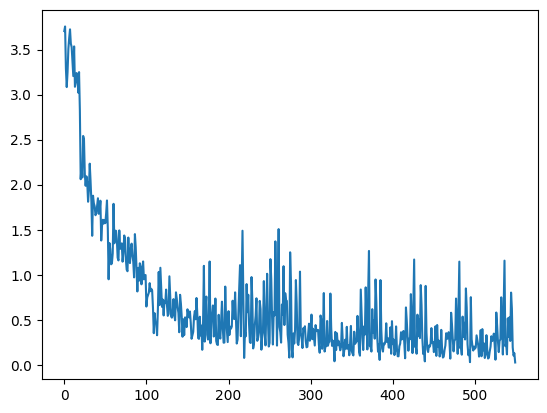

In [4]:
import matplotlib.pyplot as plt 

plt.plot(losses)

In [5]:
# save model
torch.save(agent.state_dict(), 'agent_big.pth')